# What Did The Encoder Learn?

When we talked about the neural attention mechansim we tried to learn the reverse function on variable length strings, now we will focus on what the encoder actually learned in order to generalize the reverse function.

# Can The Encoder Count?

1st we argue that in order to learn the reverse function our encoder needs to learn how to count the index of each input charcter, in order to test our assumpution we will do it by testing if the training of the network help us to predict the step of each encoder output.

In [1]:
%matplotlib inline

from models import AttentionNetwork, EncoderDecoderNetwork
from sklearn import linear_model
import numpy as np
import dynet as dy
import data
from collections import defaultdict
from random import shuffle
from copy import copy

class AttentionNetworkPredictEncoder(EncoderDecoderNetwork):
    def __init__(self, enc_layers, dec_layers, embeddings_size, enc_state_size, dec_state_size):
        EncoderDecoderNetwork.__init__(self, enc_layers, dec_layers, embeddings_size, enc_state_size, dec_state_size)
        self.encoder_outputs = defaultdict(list)
        self.should_save = False

    def _encode_string(self, embedded_string):
        initial_state = self.ENC_RNN.initial_state()

        # run_rnn returns all the hidden state of all the slices of the RNN
        hidden_states = self._run_rnn(initial_state, embedded_string)
        
        #save the encoder outputs by their step number if needed
        if self.should_save:
            for i, vec in enumerate(hidden_states):
                self.encoder_outputs[i].append(vec.npvalue())
        return hidden_states

    def _create_dataset(self, encoder_outputs):
        dataset = []
        for step in self.encoder_outputs:
            vecs = self.encoder_outputs[step]
            for vec in vecs:
                dataset.append((vec, step))
        shuffle(dataset)
        
        cut = int(len(dataset)*9/10)

        train = dataset[:cut]
        val = dataset[cut:]
        return train, val
    
    def predict_encoder_step(self, input_strings):
        self.should_save = True
        #generate outputs over input strings
        for input_string in input_strings:
            self.generate(input_string)
        self.should_save = False
        
        #create encoded character to step dataset
        train, val = self._create_dataset(self.encoder_outputs)
        data, target = list(zip(*train))
        val_data, val_target = zip(*val)
        
        #predict the step using linear model
        clf = linear_model.LassoLars(alpha=0.01)
        
        data = np.array(data)
        target = np.array(target)
        y_pred = clf.fit(data, target).predict(val_data)
        error = []
        for i in range(len(y_pred)):
            error.append(np.abs(val_target[i] - y_pred[i]))
        self.encoder_outputs = defaultdict(list)
        return np.mean(error)

Error on an untrained model:

In [2]:
ENC_RNN_NUM_OF_LAYERS = 1
DEC_RNN_NUM_OF_LAYERS = 1
EMBEDDINGS_SIZE = 4
ENC_STATE_SIZE = 32
DEC_STATE_SIZE = 32

long_sequences = [data.sample_model(14, 15)[0] for _ in range(2000)]
att = AttentionNetworkPredictEncoder(
    ENC_RNN_NUM_OF_LAYERS, DEC_RNN_NUM_OF_LAYERS, EMBEDDINGS_SIZE, ENC_STATE_SIZE, DEC_STATE_SIZE)

print(att.predict_encoder_step(long_sequences))

3.4365263479


Error on trained model:

In [3]:
def train(network, train_set, val_set, epochs=10):
    def get_val_set_loss(network, val_set):
        loss = [network.get_loss(input_string, output_string).value() for input_string, output_string in val_set]
        return sum(loss)


    train_set = train_set * epochs
    trainer = dy.SimpleSGDTrainer(network.model)
    for i, training_example in enumerate(train_set):
        input_string, output_string = training_example

        loss = network.get_loss(input_string, output_string)
        loss.value()
        loss.backward()
        trainer.update()
        
    val_loss = get_val_set_loss(network, val_set)
    return val_loss

train(att, data.train_set, data.val_set)
print(att.predict_encoder_step(long_sequences))

2.16535875803


Let's if we train our network on a task that not require a learning the order of each character. We will use the sort function:

In [4]:
from random import choice, randrange

def sample_model_sort(min_length, max_lenth):
    random_length = randrange(min_length, max_lenth)                             # Pick a random length
    random_char_list = [choice(data.characters[:-1]) for _ in range(random_length)]  # Pick random chars
    random_string = ''.join(random_char_list)
    random_char_list.sort()
    sorted_string = ''.join(random_char_list)
    return random_string, sorted_string  # Return the random string and its reverse

train_set = [sample_model_sort(1, data.MAX_STRING_LEN) for _ in range(3000)]
val_set = [sample_model_sort(1, data.MAX_STRING_LEN) for _ in range(50)]

long_sequences = [data.sample_model(14, 15)[0] for _ in range(2000)]
att = AttentionNetworkPredictEncoder(
    ENC_RNN_NUM_OF_LAYERS, DEC_RNN_NUM_OF_LAYERS, EMBEDDINGS_SIZE, ENC_STATE_SIZE, DEC_STATE_SIZE)

print(att.predict_encoder_step(long_sequences))

2.86643835838


As we can see an encoder trained on a task that requiers knowing the charcter index can predict the index much better.

# Does The Encoder Learn The Input Distribution?

Another assumption about the encoder is that he learns the distribution of the input. we will test it by seeing if input generated by a simpler distribution can be learned by a simpler encoder.

Let's see how the encoder size effects our output:

In [5]:
import matplotlib.pyplot as plt

def plot_preformence_by_encoder_size(Model, train_set, val_set):
    ENC_RNN_NUM_OF_LAYERS = 1
    DEC_RNN_NUM_OF_LAYERS = 1
    EMBEDDINGS_SIZE = 4

    iterations = []
    losses = []
    for i in range(1, 32):
        model = Model(ENC_RNN_NUM_OF_LAYERS, DEC_RNN_NUM_OF_LAYERS, EMBEDDINGS_SIZE, i, i)
        loss = train(model, train_set, val_set)
        iterations.append(i)
        losses.append(loss)
    plt.plot(iterations, losses)
    plt.axis([4, 32, 0, len(data.val_set) * data.MAX_STRING_LEN])
    plt.show()

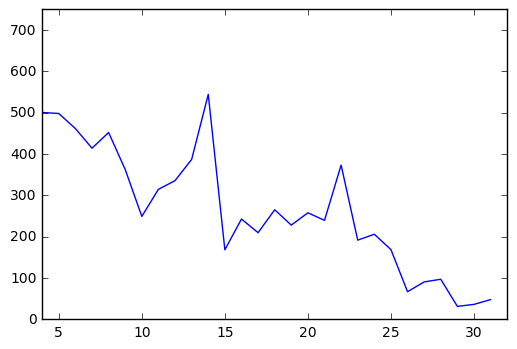

In [6]:
plot_preformence_by_encoder_size(AttentionNetwork, data.train_set, data.val_set)

In [8]:
characters = list("abcd")
characters.append(data.EOS)

def sample_model(min_length, max_lenth):
    random_length = randrange(min_length, max_lenth)
    random_char_list = []
    for i in range(random_length):
        if i%2 == 0:
            random_char_list.append(choice(data.characters[:-1][0::2]))
        else:
            random_char_list.append(choice(data.characters[:-1][1::2]))
    random_string = ''.join(random_char_list)
    return random_string, random_string[::-1]

train_set = [sample_model(1, data.MAX_STRING_LEN) for _ in range(3000)]
val_set = [sample_model(1, data.MAX_STRING_LEN) for _ in range(50)]

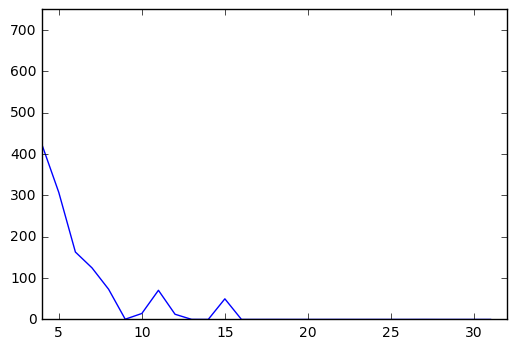

In [9]:
plot_preformence_by_encoder_size(AttentionNetwork, train_set, val_set)